In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
data_dir = "/content/drive/My Drive/LICAP_Dataset/" 
dir_loc = "/content/drive/My Drive/LICAP_Dataset/*"

In [16]:
print("Dataset Distribution")
class_names = []
for folder_name in glob.glob(dir_loc):
  image_set = folder_name.split('/')[-1]
  image_count = len(list(glob.glob(data_dir+image_set+"/*.png")))
  print(image_set+": ", image_count)
  class_names.append(image_set)
class_names = np.array(class_names)

Dataset Distribution
Splice:  64
Good:  664
Start:  21
Delam:  29
NOT_STRIPING:  21


In [17]:
# sample image display not s
# image_addr = glob.glob(data_dir+'NOT_STRIPING'+"/*.png")[0]
# PIL.Image.open(image_addr)

In [18]:
image_count = len(list(glob.glob(data_dir+'*/*.png')))
image_count

799

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir+"*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

640
159


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:
from PIL import Image
im = Image.open('/content/drive/My Drive/LICAP_Dataset/Delam/DELAM (1).png')
np_im = np.array(im)
img_height, img_width = 256, 512

In [25]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [28]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 512, 3)
Label:  1


In [30]:
batch_size = 16
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

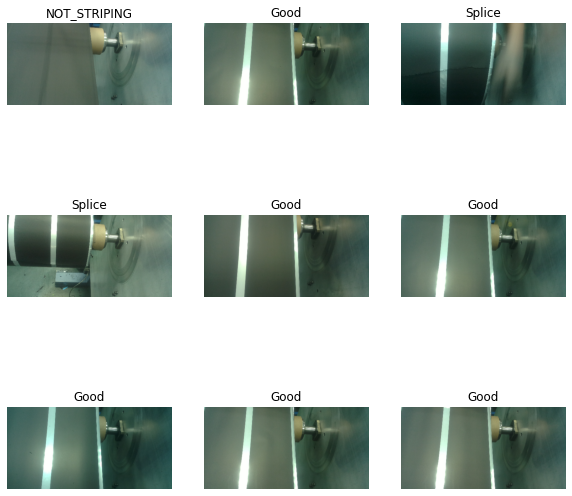

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [32]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [34]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
40/40 [==============================] - 13s 319ms/step - loss: 0.6202 - accuracy: 0.8422 - val_loss: 0.2482 - val_accuracy: 0.9371
Epoch 2/20
40/40 [==============================] - 2s 51ms/step - loss: 0.2883 - accuracy: 0.9297 - val_loss: 0.1685 - val_accuracy: 0.9560
Epoch 3/20
40/40 [==============================] - 2s 51ms/step - loss: 0.1492 - accuracy: 0.9672 - val_loss: 0.0633 - val_accuracy: 0.9874
Epoch 4/20
40/40 [==============================] - 2s 50ms/step - loss: 0.1078 - accuracy: 0.9719 - val_loss: 0.0961 - val_accuracy: 0.9937
Epoch 5/20
40/40 [==============================] - 2s 50ms/step - loss: 0.0485 - accuracy: 0.9891 - val_loss: 0.0139 - val_accuracy: 0.9937
Epoch 6/20
40/40 [==============================] - 2s 51ms/step - loss: 0.0378 - accuracy: 0.9937 - val_loss: 0.0516 - val_accuracy: 0.9937
Epoch 7/20
40/40 [==============================] - 2s 51ms/step - loss: 0.0278 - accuracy: 0.9906 - val_loss: 0.0387 - val_accuracy: 0.9937
Epoch 8/20
